In [11]:
import nidaqmx
from nidaqmx.constants import LineGrouping,Edge, AcquisitionType, VoltageUnits, TerminalConfiguration, READ_ALL_AVAILABLE
# from nidaqmx import stream_readers
from nidaqmx.stream_writers import DigitalSingleChannelWriter, DigitalMultiChannelWriter
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import matplotlib.pyplot as plt

In [32]:
system = nidaqmx.system.System.local()  # load local system

task_names = system.tasks.task_names  # returns a list of task names

## 2D Fast Open-loop Scan
fast but distorted, the slow axis drifts 

Read sample rate for NIDAQ:200000.0
Scan sample rate:71.99424046076314
Number of data per Scan point: 5556
Estimated Scanning Time:5.556 s
Trigger pulses for fast axis [  0   0   0 ... 512 512 512]
Trigger pulses for slow axis [   0    0    0 ... 1024 1024 1024]
Number of Sample to read: 1111200
timerout_readpoint: 10s


<Figure size 640x480 with 0 Axes>

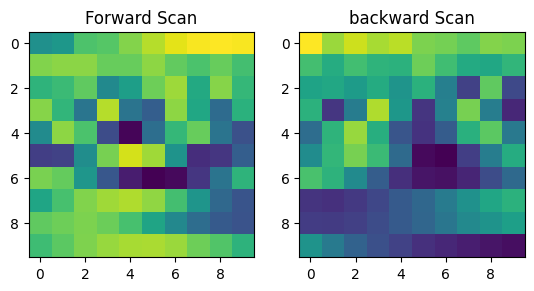

In [13]:
# hardware conneciton setting 
fastaxis = "x"
if fastaxis == "x":
    ch_forw_fa = 8 # P0 digital channel for forward motion of fast axis
    ch_back_fa = 9
    ch_forw_sa = 10
    ch_back_sa = 11 # P0 digital channel for backward motion of slow axis
elif fastaxis == "y":
    ch_forw_fa = 10 
    ch_back_fa = 11
    ch_forw_sa = 8
    ch_back_sa = 9
NI_ch_APD = "/Dev1/ai16"
NI_ch_Clock = "/Dev1/PFI8" # clock source
NI_ch_Trig = "/Dev1/PFI9" # clock gate
NI_ch_XYZstageTrig = "/Dev1/port0/line8:13"

# signal reading parameters
min_volt = -1 # [V]
max_volt = 1
samplerate_read = 0.20E6 # 500kHz .max ext clock rate of NI6343
timeout_read = 10
# scan parameters
rate_slipstick = 4000E3 # [mHz],  from 1Hz to 5kHz
stepsperpulse = 10
basetime = 1.0/samplerate_read
dutyportion = 0.09
samplerate_scantrig = (dutyportion * (rate_slipstick/1000.0)/stepsperpulse*2)
assert samplerate_read >= samplerate_scantrig * 2
samplerate_scantrig = 1.0/((round((1.0/samplerate_scantrig)/basetime)//2)*2*basetime)
# datanum_per_scanpoint = 2*samplerate_read/samplerate_scan
datanum_per_scanpoint = int(round(2*samplerate_read/samplerate_scantrig))
assert datanum_per_scanpoint%2 == 0

num_fastaxis = 10
num_slowaxis = 10
num_scanpoint = num_fastaxis*num_slowaxis
# num_dosample = 2*2*num_scanpoint
num_readsample = 2*num_scanpoint*datanum_per_scanpoint # forward and backward so times 2
scantime = num_readsample/samplerate_read

ttl_forw_line_fa = ([0]*(datanum_per_scanpoint//2)+[2**ch_forw_fa]*(datanum_per_scanpoint//2))*num_fastaxis # use rasing edge to trigger
ttl_idle_fa = [0, 0]*datanum_per_scanpoint*num_fastaxis
ttl_back_line_fa = ([0]*(datanum_per_scanpoint//2)+[2**ch_back_fa]*(datanum_per_scanpoint//2))*num_fastaxis
ttl_scan_fa = np.array((ttl_forw_line_fa+ttl_back_line_fa)*num_slowaxis, dtype=np.uint32)

ttl_scan_sa = np.array(([0]*datanum_per_scanpoint*num_fastaxis+[2**ch_forw_sa]*datanum_per_scanpoint*num_fastaxis)*num_slowaxis, dtype=np.uint32)
dotowrite = ttl_scan_fa + ttl_scan_sa
print(f"Read sample rate for NIDAQ:{samplerate_read}")
print(f"Scan sample rate:{samplerate_scantrig}")
print(f"Number of data per Scan point: {datanum_per_scanpoint}")
print(f"Estimated Scanning Time:{scantime} s")
print(f"Trigger pulses for fast axis {str(ttl_scan_fa)}")
print(f"Trigger pulses for slow axis {str(ttl_scan_sa)}")
print(f"Number of Sample to read: {num_readsample}")

buffer_readpoint = np.zeros(datanum_per_scanpoint, dtype=np.float64, order='C')
buffer_read = np.zeros(num_readsample, dtype=np.float64, order='C')
scandata_forw = np.zeros((num_slowaxis, num_fastaxis), dtype=np.float64, order='C')
scandata_back = np.zeros((num_slowaxis, num_fastaxis), dtype=np.float64, order='C')
scantask = nidaqmx.Task("scanner")
readtask = nidaqmx.Task("readsignal")


try:
    scantask.do_channels.add_do_chan(NI_ch_XYZstageTrig)
    scantask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
    scan_trig = scantask.triggers.start_trigger
    scan_trig.cfg_dig_edge_start_trig("/Dev1/PFI9", Edge.RISING)
    writestream = DigitalSingleChannelWriter(scantask.out_stream, auto_start=False)
    written = writestream.write_many_sample_port_uint32(dotowrite, timeout=10)

    readtask.ai_channels.add_ai_voltage_chan(
                NI_ch_APD,"",
                # TerminalConfiguration.RSE,
                TerminalConfiguration.DIFF,
                min_volt,max_volt,
                VoltageUnits.VOLTS
            )
    readtask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
    read_trig = readtask.triggers.start_trigger
    read_trig.cfg_dig_edge_start_trig(NI_ch_Trig, Edge.RISING)
    reader = AnalogSingleChannelReader(readtask.in_stream)
            # reader = stream_readers.AnalogMultiChannelReader(task.in_stream)
    reader.read_all_avail_samp  = True

    scantask.start() #start scanning
    readtask.start() #start scanning
    timerout_readpoint = max(datanum_per_scanpoint/samplerate_read/2*100, 10)
    # print()
    print(f"timerout_readpoint: {timerout_readpoint}s")
    for ii in range(num_slowaxis):
        # forward scan points
        for jj in range(num_fastaxis):
            num_read = reader.read_many_sample(
                    buffer_readpoint,
                    datanum_per_scanpoint,
                    timerout_readpoint
                )
            if num_read == datanum_per_scanpoint:
                idx = (ii*num_fastaxis+jj)*datanum_per_scanpoint*2
                buffer_read[idx:idx+datanum_per_scanpoint] = np.copy(buffer_readpoint)
                scandata_forw[ii, jj] = np.mean(buffer_readpoint)
                # print("read data for a scan")
            else:
                print(f"forward scan point fucked...at i={ii}, j={jj}")
        # backward scan points
        for jj in range(num_fastaxis):
            num_read = reader.read_many_sample(
                    buffer_readpoint,
                    datanum_per_scanpoint,
                    timerout_readpoint
                )
            if num_read == datanum_per_scanpoint:
                idx = (ii*num_fastaxis+jj)*datanum_per_scanpoint*2
                buffer_read[idx+datanum_per_scanpoint:idx+2*datanum_per_scanpoint] = np.copy(buffer_readpoint)
                scandata_back[ii, jj] = np.mean(buffer_readpoint)
                # print("read data for a scan")
            else:
                print(f"backward scan point fucked...at i={ii}, j={jj}")

    scantask.wait_until_done(timeout=max(scantime*10, 10)) # block the code below, optional
    scantask.stop()
    readtask.stop()
except Exception as ee:
    print(ee)
finally:
    scantask.close()
    readtask.close()

# show the scans 
plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].set_title("Forward Scan")
axarr[0].imshow(scandata_forw)
axarr[1].set_title("backward Scan")
axarr[1].imshow(scandata_back)
plt.show()

## Raster Scan
### fast open-loop line scan + slow close-loop line scan
positioner comes back to starting pointing point after each line,
use close loop for slow axis, open loop for fast axis


Read sample rate for NIDAQ:200000.0
Scan sample rate:20.990764063811923
Number of data per Scan point: 19056
Estimated Line Scan Time:0.28584 s
Trigger pulses for fast axis [  0   0   0 ... 256 256 256]
Number of Sample to read: 57168
timerout_readpoint: 10s
read data for a scan
read data for a scan
read data for a scan
read data for a scan
read data for a scan
read data for a scan
read data for a scan
read data for a scan
read data for a scan
read data for a scan
read data for a scan
read data for a scan
read data for a scan
read data for a scan
read data for a scan
[[0.03507144 0.03557365 0.03532854]
 [0.03496947 0.03561954 0.03540493]
 [0.03484769 0.03561375 0.03549802]
 [0.0349426  0.03560652 0.03542858]
 [0.03489312 0.03560121 0.03549965]]


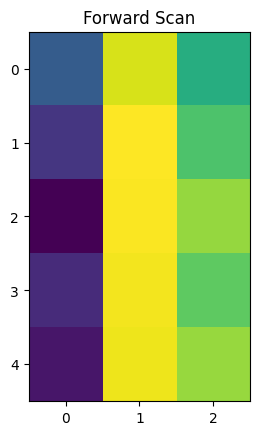

In [31]:
# hardware conneciton setting 
fastaxis = "x"
if fastaxis == "x":
    ch_forw = 8 # P0 digital channel for forward motion of fast axis
    ch_back = 9
elif fastaxis == "y":
    ch_forw = 10 
    ch_back = 11

# signal reading parameters
min_volt = -1 # [V]
max_volt = 1
samplerate_read = 0.20E6 # 500kHz .max ext clock rate of NI6343
basetime = 1.0/samplerate_read
timeout_read = 10

# scan parameters
rate_slipstick = 2099E3 # [mHz],  from 1Hz to 5kHz
stepsperpulse = 20
dutyportion = 0.1
num_fastaxis = 3
num_slowaxis = 5
pos_begin_fa = 500E3
poslist_end_fa = np.zeros(num_slowaxis) # the end position of the fast is unknown in advance because it travels in open loop, it will be measured for each scan line
pos_begin_sa = 500E3 # use absolute position in nm
pos_end_sa = 1000E3 # use absolute position in nm
travellist_sa = np.linspace(pos_begin_sa, pos_end_sa, num_slowaxis, endpoint=True)


samplerate_scantrig = (dutyportion * (rate_slipstick/1000.0)/stepsperpulse*2)
assert samplerate_read >= samplerate_scantrig 
samplerate_scantrig = 1.0/((round((1.0/samplerate_scantrig)/basetime)//2)*2*basetime)
# datanum_per_scanpoint = 2*samplerate_read/samplerate_scan
datanum_per_scanpoint = int(round(2*samplerate_read/samplerate_scantrig))
assert datanum_per_scanpoint%2 == 0
num_readsample = num_fastaxis*datanum_per_scanpoint 






ttl_forw_line_fa = ([0]*(datanum_per_scanpoint//2) + [2**ch_forw]*(datanum_per_scanpoint//2))*num_fastaxis # use rasing edge to trigger
linescantime = num_readsample/samplerate_read
ttl_scan_fa = np.array(ttl_forw_line_fa, dtype=np.uint32)
dotowrite = ttl_scan_fa 

print(f"Read sample rate for NIDAQ:{samplerate_read}")
print(f"Scan sample rate:{samplerate_scantrig}")
print(f"Number of data per Scan point: {datanum_per_scanpoint}")
print(f"Estimated Line Scan Time:{linescantime} s")
print(f"Trigger pulses for fast axis {str(ttl_scan_fa)}")
print(f"Number of Sample to read: {num_readsample}")

buffer_readpoint = np.zeros(datanum_per_scanpoint, dtype=np.float64, order='C')
scandata = np.zeros((num_slowaxis, num_fastaxis), dtype=np.float64, order='C')

scantask = nidaqmx.Task("scanner")
readtask = nidaqmx.Task("readsignal")


try:
    scantask.do_channels.add_do_chan(NI_ch_XYZstageTrig)
    scantask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
    scan_trig = scantask.triggers.start_trigger
    scan_trig.cfg_dig_edge_start_trig("/Dev1/PFI9", Edge.RISING)

    readtask.ai_channels.add_ai_voltage_chan(
                NI_ch_APD,"",
                # TerminalConfiguration.RSE,
                TerminalConfiguration.DIFF,
                min_volt,max_volt,
                VoltageUnits.VOLTS
            )
    readtask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
    read_trig = readtask.triggers.start_trigger
    read_trig.cfg_dig_edge_start_trig(NI_ch_Trig, Edge.RISING)

    timerout_readpoint = max(datanum_per_scanpoint/samplerate_read, 10)
    # print()
    print(f"timerout_readpoint: {timerout_readpoint}s")
    # for ii in range(num_slowaxis):
    for ii in range(num_slowaxis):
        writestream = DigitalSingleChannelWriter(scantask.out_stream, auto_start=False)
        written = writestream.write_many_sample_port_uint32(dotowrite, timeout=10)

        reader = AnalogSingleChannelReader(readtask.in_stream)
                # reader = stream_readers.AnalogMultiChannelReader(task.in_stream)
        reader.read_all_avail_samp  = True

        scantask.start() #start line scanning
        readtask.start() #start reading data
        
        # forward scan points
        for jj in range(num_fastaxis):
            num_read = reader.read_many_sample(
                    buffer_readpoint,
                    datanum_per_scanpoint,
                    timerout_readpoint
                )
            if num_read == datanum_per_scanpoint:
                idx = (ii*num_fastaxis+jj)*datanum_per_scanpoint
                scandata[ii, jj] = np.mean(buffer_readpoint)
                print("read data for a scan")
            else:
                print(f"forward scan point fucked...at i={ii}, j={jj}")
        scantask.wait_until_done(timeout=max(linescantime, 10)) # block the code below, optional
        readtask.wait_until_done(timeout=max(linescantime, 10)) # block the code below, optional
        scantask.stop()
        readtask.stop()
except Exception as ee:
    print(ee)
finally:
    scantask.close()
    readtask.close()

# show the scans 
print(scandata)
plt.figure()
plt.imshow(scandata)
plt.title("Forward Scan")
plt.show()

In [ ]:
scantask.close()